In [3]:
# ---------------------------------------------------------
# 1. IMPORT LIBRARIES
# ---------------------------------------------------------
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8,5)

# ---------------------------------------------------------
# 2. LOAD DATA
# ---------------------------------------------------------
DATA_DIR = Path("data")

def load_split(name):
    path = DATA_DIR / f"{name}.json"
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    return raw

train = load_split("train")
valid = load_split("valid")
test = load_split("test")

print(f"Train samples: {len(train)}")
print(f"Valid samples: {len(valid)}")
print(f"Test samples:  {len(test)}")

# ---------------------------------------------------------
# 3. CONVERT TO DATAFRAMES
# ---------------------------------------------------------
def flatten(records, split):
    rows = []
    for r in records:
        rows.append({
            "split": split,
            "id": r["id"],
            "pre_tokens": sum(len(t.split()) for t in r["pre_text"]),
            "post_tokens": sum(len(t.split()) for t in r["post_text"]),
            "table_rows": len(r["table"]),
            "table_cols": len(r["table"][0]) if r["table"] else 0,
            "question_len": len(r["qa"]["question"].split()),
            "program": r["qa"]["program"],
            "answer": r["qa"]["exe_ans"]
        })
    return rows

df = pd.DataFrame(flatten(train, "train") +
                  flatten(valid, "valid") +
                  flatten(test,  "test"))

df.head()


Train samples: 2993
Valid samples: 584
Test samples:  497


,split,id,pre_tokens,post_tokens,table_rows,table_cols,question_len,program,answer
0,train,PM/2017/page_25.pdf-1,116,209,7,4,17,"subtract(108.50, 100), divide(#0, 100)",0.085
1,train,masvn/2021/2021025-VN_HBC_Update_Sell_1Q21/pag...,322,1,9,7,17,"multiply(11228, 1.03)",11564.84
2,train,ETR/2016/page_342.pdf-1,300,168,8,2,15,"subtract(2438.4, 2408.8), divide(#0, 2408.8)",0.01229
3,train,masvn/2020/2020126-PVT_Companynote_MAS29.09.20...,613,1,10,7,18,"subtract(7.758, 7.523), divide(#0, 7.523)",0.03124
4,train,masvn/2020/2020009-190416_VCB_2018review_VN/pa...,769,1,10,8,17,"add(6851, 9091), add(#0, 14606)",30548.0


In [4]:
# ---------------------------------------------------------
# 4. BASIC STATISTICS
# ---------------------------------------------------------
print("Total samples:", len(df))
df.groupby("split").size()


Total samples: 4074


split
test      497
train    2993
valid     584
dtype: int64

In [5]:
# Length stats
df[["pre_tokens","post_tokens","question_len"]].describe()


,pre_tokens,post_tokens,question_len
count,4074.000000,4074.000000,4074.000000
mean,419.092784,221.701522,20.623466
std,257.346036,330.635986,6.751061
min,1.000000,1.000000,6.000000
25%,219.250000,1.000000,16.000000
50%,422.000000,1.000000,19.000000
75%,576.000000,383.000000,24.000000
max,1712.000000,2086.000000,66.000000


In [6]:
# Table dimension stats
df[["table_rows","table_cols"]].describe()


,table_rows,table_cols
count,4074.000000,4074.000000
mean,8.216004,5.299460
std,3.052528,1.918846
min,2.000000,2.000000
25%,6.000000,4.000000
50%,9.000000,6.000000
75%,10.000000,7.000000
max,29.000000,10.000000


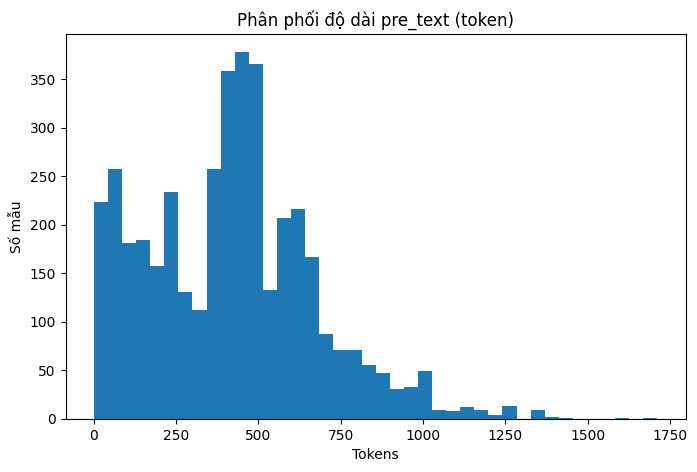

In [7]:
# ---------------------------------------------------------
# 5. VISUALIZATION
# ---------------------------------------------------------

# Histogram: độ dài pre_text
plt.hist(df.pre_tokens, bins=40)
plt.title("Phân phối độ dài pre_text (token)")
plt.xlabel("Tokens")
plt.ylabel("Số mẫu")
plt.show()


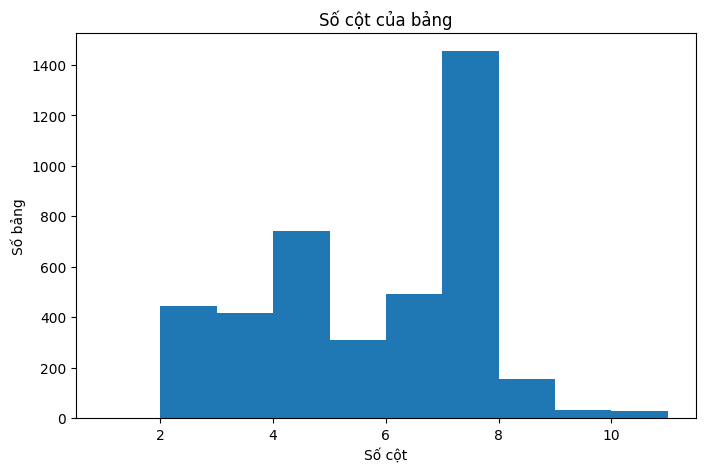

In [8]:
# Histogram: chiều rộng bảng
plt.hist(df.table_cols, bins=range(1, df.table_cols.max()+2))
plt.title("Số cột của bảng")
plt.xlabel("Số cột")
plt.ylabel("Số bảng")
plt.show()


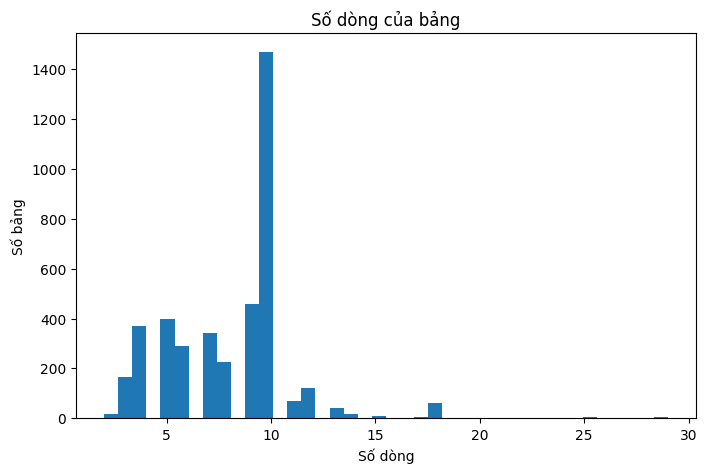

In [9]:
# Histogram: số dòng bảng
plt.hist(df.table_rows, bins=40)
plt.title("Số dòng của bảng")
plt.xlabel("Số dòng")
plt.ylabel("Số bảng")
plt.show()


In [16]:
# ---------------------------------------------------------
# 6. PROGRAM & QUESTION ANALYSIS (SIMPLE SINGLE-OP FORM)
# ---------------------------------------------------------

import re

def extract_op(p):
    """
    Trích toán tử dạng <op>(x, y).
    Ví dụ: add(#1, 20) -> add
    """
    m = re.match(r"\s*([a-zA-Z_]+)\s*\(", p)
    return m.group(1) if m else "UNKNOWN"

def extract_args(p):
    """
    Tách hai đối số bên trong op(x, y).
    Ví dụ: add(#1, 20) -> ['#1','20']
    """
    inside = re.search(r"\((.*)\)", p)
    if not inside:
        return []
    args = inside.group(1).split(",")
    return [a.strip() for a in args]

df["op"] = df.program.apply(extract_op)
df["args"] = df.program.apply(extract_args)

print("Operators found:")
print(df.op.value_counts())


Operators found:
op
subtract         1778
divide            998
add               540
table_max         238
multiply          175
table_average     170
table_min         103
table_sum          71
greater             1
Name: count, dtype: int64


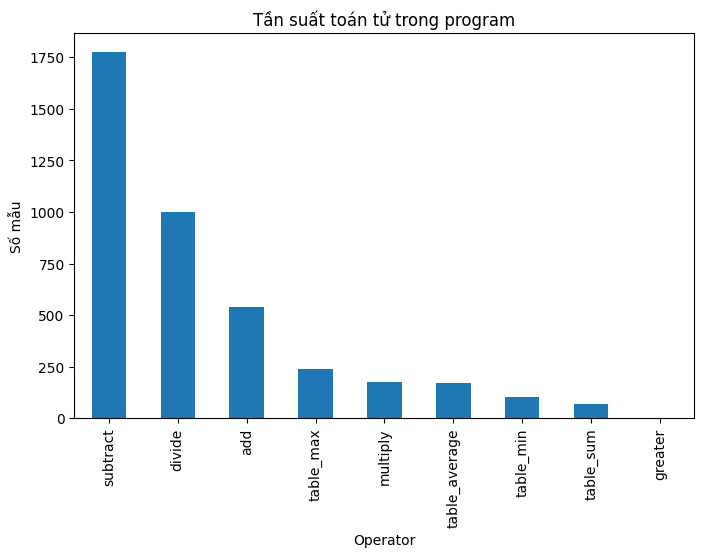

In [17]:
df.op.value_counts().plot(kind="bar")
plt.title("Tần suất toán tử trong program")
plt.xlabel("Operator")
plt.ylabel("Số mẫu")
plt.show()


In [ ]:
# ---------------------------------------------------------
# 7. PROGRAM LENGTH ANALYSIS
# ---------------------------------------------------------
import re

def count_ops(p):
    """
    Đếm số lần xuất hiện toán tử dạng <op>(
    Ví dụ:
        add(1,2)              -> 1
        mul(add(1,2),3)       -> 2  (dù bạn nói không có lồng, vẫn phòng xa)
    """
    return len(re.findall(r"[a-zA-Z_]+\s*\(", p))

df["num_ops"] = df.program.apply(count_ops)

print("\nSố phép tính (operator) trong mỗi program:")
print(df["num_ops"].value_counts())

print("\nThống kê num_ops:")
print(df["num_ops"].describe())



Số phép tính (operator) trong mỗi program:
num_ops
1    2065
2    1709
3     170
5      71
4      52
6       5
7       2
Name: count, dtype: int64

Thống kê num_ops:
count    4074.000000
mean        1.620029
std         0.802617
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         7.000000
Name: num_ops, dtype: float64


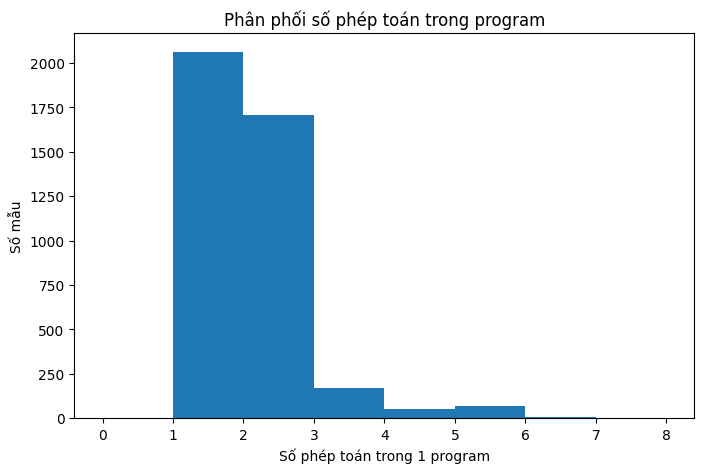

In [20]:
plt.hist(df.num_ops, bins=range(df.num_ops.max()+2))
plt.title("Phân phối số phép toán trong program")
plt.xlabel("Số phép toán trong 1 program")
plt.ylabel("Số mẫu")
plt.show()


In [ ]:
# ---------------------------------------------------------
# 8. XEM MỘT VÍ DỤ
# ---------------------------------------------------------

def show_example(split_df):
    row = split_df.sample(1).iloc[0]
    print("ID:", row.id)
    sample = train if row.split=="train" else valid if row.split=="valid" else test
    record = next(r for r in sample if r["id"] == row.id)

    print("\nQUESTION:", record["qa"]["question"])
    print("PROGRAM :", record["qa"]["program"])
    print("ANSWER  :", record["qa"]["exe_ans"])
    print("\nPRE_TEXT:", " ".join(record["pre_text"])[:600], "...")  # cắt ngắn
    print("\nTABLE:")
    for row in record["table"]:
        print(row)

show_example(df[df.split=="train"])


ID: GS/2012/page_186.pdf-2

QUESTION: Tính đến tháng 12 năm 2012 và 2011, tổng vốn tối thiểu là bao nhiêu, tính bằng triệu?
PROGRAM : table_min(tổng vốn, none)
ANSWER  : 77143.0

PRE_TEXT: thuyết minh báo cáo tài chính hợp nhất ghi chú 20. quy định và mức độ an toàn vốn cục dự trữ liên bang là cơ quan quản lý chính của group inc. , một công ty mẹ ngân hàng theo đạo luật công ty mẹ ngân hàng năm 1956 ( đạo luật bhc ) và là một công ty mẹ tài chính theo các sửa đổi của đạo luật bhc được thực hiện bởi đạo luật gramm-leach-bliley của hoa kỳ năm 1999. với tư cách là một công ty mẹ ngân hàng , công ty phải tuân thủ các yêu cầu về vốn điều lệ hợp nhất được tính toán theo các yêu cầu về vốn dựa trên rủi ro của cục dự trữ liên bang ( dựa trên hiệp ước vốn basel 1 2019 của ủy ban basel ). ...

TABLE:
['triệu đô la', 'tính đến tháng 12 năm 2012', 'tính đến tháng 12 năm 2011']
['vốn cấp 1', '$ 66977', '$ 63262']
['vốn cấp 2', '$ 13429', '$ 13881']
['tổng vốn', '$ 80406', '$ 77143']
['tài sản có rủ